In [88]:
import pandas as pd
from econml.metalearners import TLearner
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv("data/email_data.csv")
df['treatment'] = df['segment'].map({'No E-Mail': 0, 'Womens E-Mail': 1, 'Mens E-Mail': 2})
df = df.query('treatment in [0,1]')
n = df.shape[0]
df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1


In [72]:
# Features, treatment, and outcome
X = df[['recency', 'mens', 'womens']]
T = df['treatment']
y = df['conversion']

In [73]:
# Split the data into train and test
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)

In [86]:
# Let's use the t-learner as the causal inference model with XGBoost as the underlying estimator
t_learner = TLearner(models=GradientBoostingRegressor(n_estimators=100, max_depth=10, min_samples_leaf=int(n/100)))

NameError: name 'TLearnerCV' is not defined

In [81]:
# Fit the model
t_learner.fit(y_train, T_train, X=X_train)

In [82]:
ite_test = t_learner.effect(X_test)
T_test

7730     0
17594    1
14481    1
20003    1
19981    0
        ..
56287    0
49518    0
6397     1
57944    0
39945    0
Name: treatment, Length: 8539, dtype: int64

In [83]:
ite_test

array([-0.00060955,  0.00512717, -0.00504729, ..., -0.00046733,
        0.00913174,  0.00572181])

In [84]:
# Calculate the ROC curve and AUC for the estimated uplift on the test set
fpr, tpr, thresholds = roc_curve(T_test, ite_test)
roc_auc = auc(fpr, tpr)

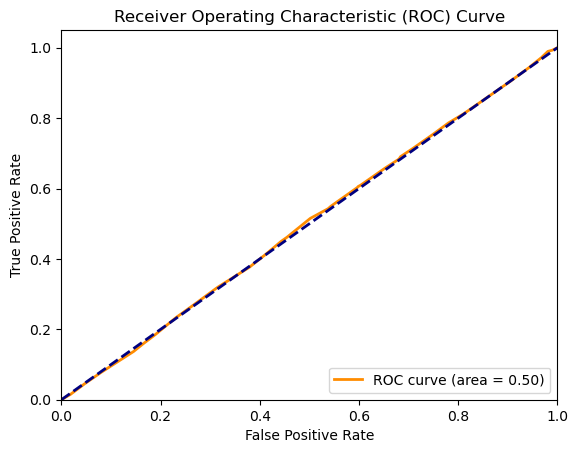

AUC for T-Learner uplift model: 0.50


In [85]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for T-Learner uplift model: {roc_auc:.2f}")